Epoch 1/82
152/152 [==============================] - 739s 5s/step - loss: 1.7509 - accuracy: 0.3148 - val_loss: 1.5768 - val_accuracy: 0.3925
Epoch 2/82
152/152 [==============================] - 738s 5s/step - loss: 1.5501 - accuracy: 0.4003 - val_loss: 1.4936 - val_accuracy: 0.4369
Epoch 3/82
152/152 [==============================] - 748s 5s/step - loss: 1.4522 - accuracy: 0.4428 - val_loss: 1.4515 - val_accuracy: 0.4331
Epoch 4/82
152/152 [==============================] - 739s 5s/step - loss: 1.4355 - accuracy: 0.4472 - val_loss: 1.3811 - val_accuracy: 0.4919
Epoch 5/82
152/152 [==============================] - 767s 5s/step - loss: 1.3665 - accuracy: 0.4792 - val_loss: 1.3771 - val_accuracy: 0.4706
Epoch 6/82
152/152 [==============================] - 796s 5s/step - loss: 1.3462 - accuracy: 0.4924 - val_loss: 1.3880 - val_accuracy: 0.4725
Epoch 7/82
152/152 [==============================] - 736s 5s/step - loss: 1.3046 - accuracy: 0.5134 - val_loss: 1.3372 - val_accuracy: 0.4981

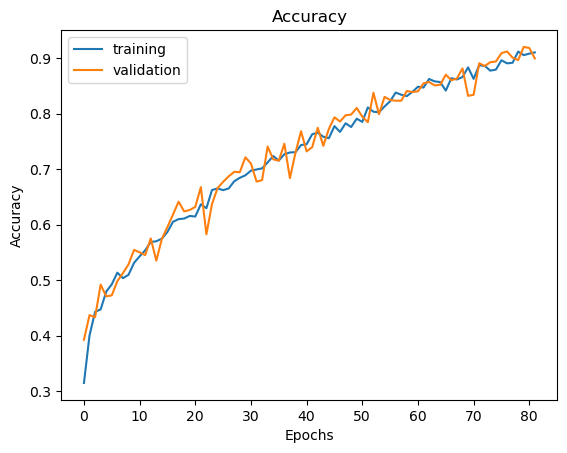

/Users/jangminjun/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # train-test split을 위해 추가
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# TensorFlow GPU 메모리 동적 관리 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 데이터셋 디렉토리 경로 설정
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# ResNet-50 모델 불러오기 및 커스터마이징
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 862, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# 최종 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# ResNet-50 기본 모델 레이어를 고정하여 학습되지 않도록 함
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터셋 및 레이블 생성 함수
def generate_data(data_dir, class_labels, batch_size, is_training=True):
    while True:
        batch_X = []
        batch_labels = []
        data_to_use = os.listdir(data_dir)
        
        if is_training:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[0]
        else:
            data_to_use = train_test_split(data_to_use, test_size=0.2, random_state=42)[1]
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # 수정된 부분: class_dir 내에 있는 파일들을 이용해 무작위로 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 모델 학습 및 validation 데이터 사용
batch_size = 32
steps_per_epoch = 152
epochs = 82

# 훈련 데이터셋 생성 함수
train_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=True)

# 테스트 데이터셋 생성 함수
test_data_generator = generate_data(data_dir, class_labels, batch_size, is_training=False)

# 모델 학습
history = model.fit(
    train_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=test_data_generator,
    validation_steps=50)

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')  # 검증 데이터 정확도 추가
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


model.save('resnet.h5')

In [2]:
from tensorflow.keras.models import load_model
loaded_model = load_model('resnet.h5')


In [3]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 862, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 868, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 431, 64)          9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 431, 64)          256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [4]:
def preprocess_input(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
    mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
    RATIO = 862 / 64
    mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                 anti_aliasing=True, mode='reflect')
    mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
    return mel_spec_dB_stacked

# 예측 수행 함수 정의
def predict_audio(file_path):
    preprocessed_input = preprocess_input(file_path)
    preprocessed_input = np.expand_dims(preprocessed_input, axis=0)  # 배치 차원 추가
    predictions = loaded_model.predict(preprocessed_input)
    predicted_class_idx = np.argmax(predictions)
    predicted_class_label = class_labels[predicted_class_idx]
    return predicted_class_label

In [5]:
audio_file_path = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data/awake/awake_1.wav'  # 예측하려는 오디오 파일 경로로 바꾸세요.
predicted_label = predict_audio(audio_file_path)
print("예측된 클래스 레이블:", predicted_label)

1/1 [==============================] - 0s 450ms/step
예측된 클래스 레이블: awake


In [12]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model

loaded_model = load_model('resnet.h5')
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# 테스트 데이터셋 생성 함수
def generate_test_data(data_dir, class_labels, batch_size):
    while True:
        batch_X = []
        batch_labels = []
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # class_dir 내에 있는 파일들을 이용해 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 테스트 데이터셋 생성 함수 사용
test_batch_size = 32
test_data_generator = generate_test_data(data_dir, class_labels, test_batch_size)

# 모델 평가
num_test_samples = len(class_labels) * test_batch_size  # 전체 테스트 샘플 수 계산
num_test_batches = int(np.ceil(num_test_samples / test_batch_size))  # 테스트 배치 수 계산
evaluation = loaded_model.evaluate(test_data_generator, steps=num_test_batches)
print("평가 결과:", evaluation)

7/7 [==============================] - 20s 3s/step - loss: 0.4273 - accuracy: 0.8750
평가 결과: [0.42725178599357605, 0.875]


In [13]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import load_model

loaded_model = load_model('resnet.h5')
data_dir = '/Users/jangminjun/Desktop/babyproject/hear_ease-infant_crying_classification/data'
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

# 테스트 데이터셋 생성 함수
def generate_test_data(data_dir, class_labels, batch_size):
    while True:
        batch_X = []
        batch_labels = []
        
        for _ in range(batch_size):
            label_idx = np.random.randint(num_classes)
            label = class_labels[label_idx]
            class_dir = os.path.join(data_dir, label)
            
            # class_dir 내에 있는 파일들을 이용해 파일을 선택합니다.
            filename = np.random.choice(os.listdir(class_dir))
            file_path = os.path.join(class_dir, filename)

            y, sr = librosa.load(file_path, sr=16000)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=501)
            mel_spec_dB = librosa.power_to_db(mel_spec, ref=np.max)
            RATIO = 862 / 64
            mel_spec_dB_resized = resize(mel_spec_dB, (mel_spec_dB.shape[0], mel_spec_dB.shape[1] * RATIO),
                                         anti_aliasing=True, mode='reflect')
            mel_spec_dB_stacked = np.stack([mel_spec_dB_resized] * 3, axis=-1)
            batch_X.append(mel_spec_dB_stacked)
            batch_labels.append(label_idx)

        batch_X = np.array(batch_X)
        batch_labels = to_categorical(batch_labels, num_classes=num_classes)
        yield batch_X, batch_labels

# 테스트 데이터셋 생성 함수 사용
test_batch_size = 32
test_data_generator = generate_test_data(data_dir, class_labels, test_batch_size)

# 모델 평가
num_test_samples = len(class_labels) * test_batch_size  # 전체 테스트 샘플 수 계산
num_test_batches = int(np.ceil(num_test_samples / test_batch_size))  # 테스트 배치 수 계산
evaluation = loaded_model.evaluate(test_data_generator, steps=num_test_batches)
print("평가 결과:", evaluation)

7/7 [==============================] - 20s 3s/step - loss: 0.4060 - accuracy: 0.8973
평가 결과: [0.4060058891773224, 0.8973214030265808]
